# STAT-477 Final presentation

* Jackson Joffe
* October 14 2020


## Goals:

* For my final project, I am going to be examining the 'county_data.csv' dataset
* Specifically, I am going to try to construct the best model for adult obesity rates. To do this, I will identify the best predictor variables
* I will show vivid graphics to help the reader better understand the variable distributions
* To identify the best predictors, I construct a cost complexity pruning tree
* Finally, I use the top optimal variables in a multiple regression 

In [1]:
# Read in all the libraries and data
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels.formula.api as smf
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

os.chdir('/Users/jacksonjoffe/Documents/STAT 477') 
county_data = pd.read_csv("project_477.csv", index_col = "Row.Label")

In [2]:
print(county_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2715 entries, AL_Autauga County to WY_Weston County
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Five-digit.FIPS.Code              2715 non-null   int64  
 1   State.FIPS.Code                   2715 non-null   int64  
 2   County.FIPS.Code                  2715 non-null   int64  
 3   State.Abbreviation                2715 non-null   object 
 4   CountyName                        2715 non-null   object 
 5   Poor.Health                       2715 non-null   float64
 6   Election.Results.2016             2715 non-null   object 
 7   Uninsured                         2715 non-null   float64
 8   Primary.Care.Physicians.Per.1000  2715 non-null   float64
 9   Mental.health.providers.Per.1000  2715 non-null   float64
 10  Adult.Obesity                     2715 non-null   float64
 11  Proportion.of.Smokers             2715 non-nul

In [3]:
print(county_data.groupby('State.Abbreviation').describe())

                   Five-digit.FIPS.Code                                     \
                                  count          mean         std      min   
State.Abbreviation                                                           
AK                                  2.0   2018.000000    2.828427   2016.0   
AL                                 64.0   1067.500000   39.671668   1001.0   
AR                                 73.0   5073.602740   43.316259   5001.0   
AZ                                 15.0   4013.866667    8.078779   4001.0   
CA                                 57.0   6058.964912   33.257633   6001.0   
CO                                 53.0   8066.283019   36.665000   8001.0   
CT                                  6.0   9006.000000    3.741657   9001.0   
DC                                  1.0  11001.000000         NaN  11001.0   
DE                                  3.0  10003.000000    2.000000  10001.0   
FL                                 66.0  12067.772727   38.96538

## Examining the data

* Life expectancy doesn't look to be significantly different between states
* Some potential relations include Adult.Obesity and Poor.Health and Proportion.of.Smokers and Life.Expectancy
* Adult.Obesity looks to be an interesting response variable to examine given its high prevalence in modern society and the many negative health results arising from obesity
* Some potential explanatory variables could be Food.Insecurity.Quintile, Physical.Inactivity, Poor.Health, Excessive.Drinking, Insufficient.Sleep and Life.Expectancy. 
* Let's visualize Physical.Inactivity, Excessive.Drinking, and Life.Expectancy separately, each as a predictor of Adult.Obesity

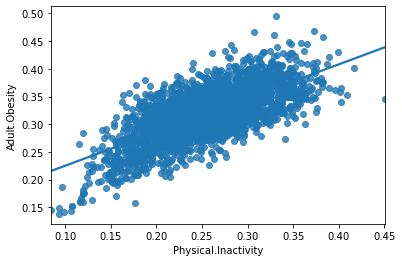

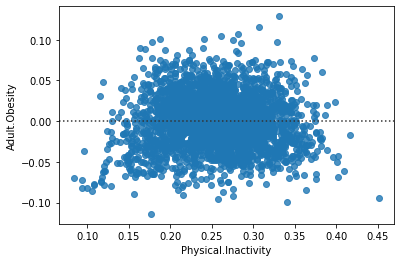

In [4]:
sns.regplot(x='Physical.Inactivity', y='Adult.Obesity', data=county_data, ci=None)
plt.show()
sns.residplot(x='Physical.Inactivity', y='Adult.Obesity', data=county_data)
plt.show()

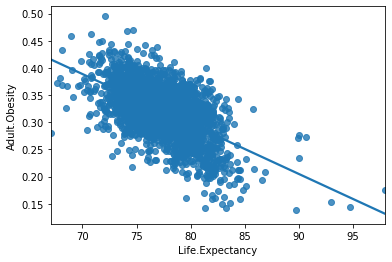

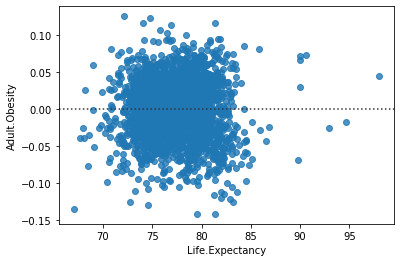

In [5]:
sns.regplot(x='Life.Expectancy', y='Adult.Obesity', data=county_data, ci=None)
plt.show()
sns.residplot(x='Life.Expectancy', y='Adult.Obesity', data=county_data)
plt.show()

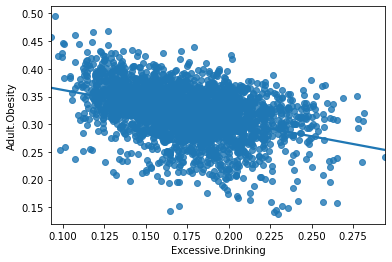

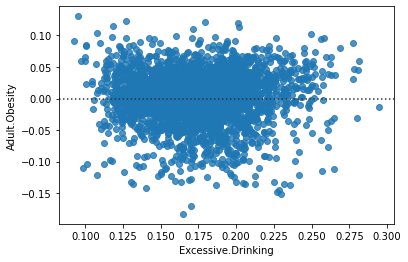

In [6]:
sns.regplot(x='Excessive.Drinking', y='Adult.Obesity', data=county_data, ci=None)
plt.show()
sns.residplot(x='Excessive.Drinking', y='Adult.Obesity', data=county_data)
plt.show()

## Takeaways:

* All three of these these individual simple regressions seem to be relatively strong
* There are no patterns in the residual plots, which is a good sign for the predictability of the variables

* Now, let's visualize the relations between our explanatory variables.

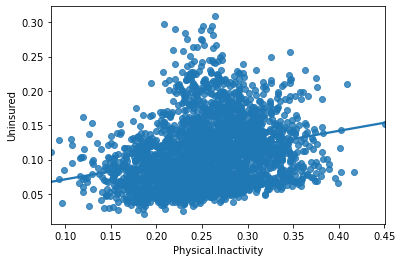

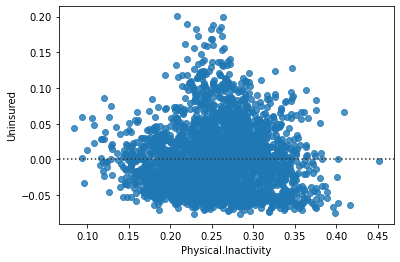

In [7]:
sns.regplot(x='Physical.Inactivity', y='Uninsured', data=county_data, ci=None)
plt.show()
sns.residplot(x='Physical.Inactivity', y='Uninsured', data=county_data)
plt.show()

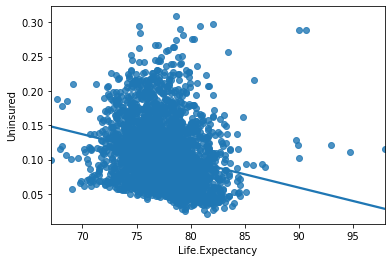

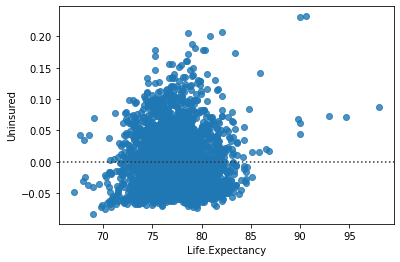

In [8]:
sns.regplot(x='Life.Expectancy', y='Uninsured', data=county_data, ci=None)
plt.show()
sns.residplot(x='Life.Expectancy', y='Uninsured', data=county_data)
plt.show()

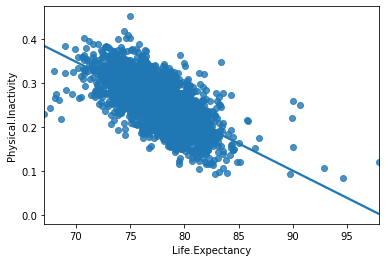

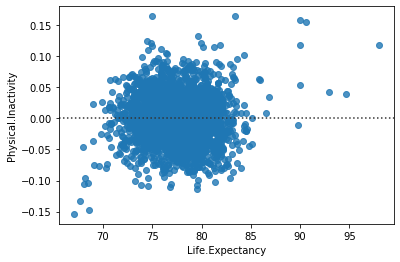

In [9]:
sns.regplot(x='Life.Expectancy', y='Physical.Inactivity', data=county_data, ci=None)
plt.show()
sns.residplot(x='Life.Expectancy', y='Physical.Inactivity', data=county_data)
plt.show()

## Takeaways:

* These plots help confirm common intuition: Life.Expectancy clearly varies inversely with Physical.Inactivity 
* The percentage of uninsured residents is not closely related to Physical.Inactivity or Life.Expectancy, which means it could be a good predictor for our model
* The residual plots show no patterns, implying that these three variables are a good combination for a model
------
* Having examined and visualized different combinations, let's use a tree to create a predictive model for Adult.Obesity

In [14]:
Xcts = county_data[['Poor.Health', 'Uninsured', 'Primary.Care.Physicians.Per.1000', 'Mental.health.providers.Per.1000', 'Proportion.of.Smokers', 'High.School.Graduation', 'Insufficient.Sleep', 'Physical.Inactivity', 'Excessive.Drinking', 'Median.Household.Income', 'Severe.Housing.Problems', 'Unemployment', 'Percent.Rural', 'Over.65', 'Percent.Females', 'Life.Expectancy', 'Population']]
Xcat = pd.get_dummies(county_data[['Food.Insecurity.Quintile', 'Income.Inequality.Quartile']])
X = pd.merge(Xcts, Xcat, left_index=True, right_index=True)
y = county_data['Adult.Obesity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=1)

dtr = tree.DecisionTreeRegressor(random_state=0)
path = dtr.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total impurity vs. effective alpha for county_data')

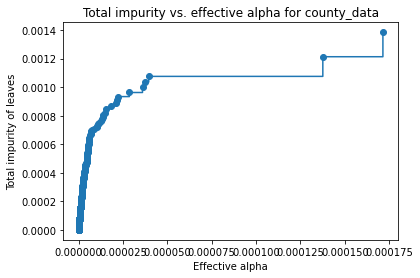

In [16]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle='steps-post')
ax.set_xlabel("Effective alpha")
ax.set_ylabel("Total impurity of leaves")
ax.set_title("Total impurity vs. effective alpha for county_data")

## Takeaways:

* Here's a visualization of total impurity vs. effective alpha for county_data
* Notice how, as we would expect, as effective alpha increases, total impurities increase
* Now, let's find the best tree for each value of alpha and visualize the complexity versus alpha plots

In [17]:
rgrs = []
for ccp_alpha in ccp_alphas:
    dtr = tree.DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    dtr.fit(X_train, y_train)
    rgrs.append(dtr)
    
rgrs = rgrs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [dtr.tree_.node_count for dtr in rgrs]
depth = [dtr.tree_.max_depth for dtr in rgrs]

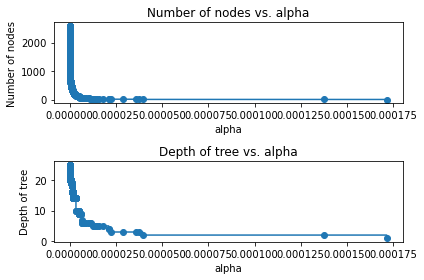

In [23]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle ='steps-post')
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("Number of nodes")
ax[0].set_title("Number of nodes vs. alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle ='steps-post')
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("Depth of tree")
ax[1].set_title("Depth of tree vs. alpha")
fig.tight_layout()

## Takeaways:

* Alpha gets larger as the tree gets less complex
* Now, let's also plot the accuracy for alpha in our test and training sets from the scoring tree 

In [20]:
train_scores = [dtr.score(X_train, y_train) for dtr in rgrs]
test_scores = [dtr.score(X_test, y_test) for dtr in rgrs]

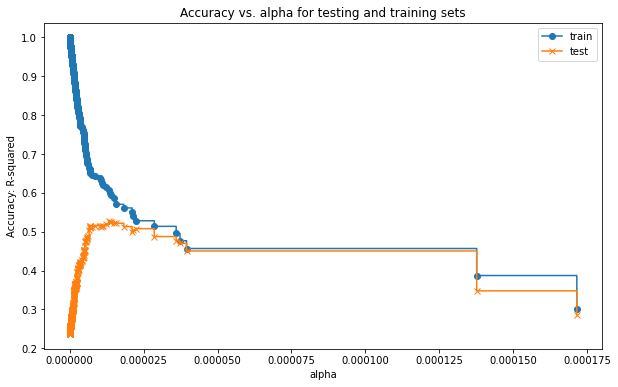

In [24]:
fix, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel("alpha")
ax.set_ylabel("Accuracy: R-squared")
ax.set_title("Accuracy vs. alpha for testing and training sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle ='steps-post')
ax.plot(ccp_alphas, test_scores, marker='x', label="test", drawstyle ='steps-post')
ax.legend()
plt.show()

## Takeaways:

* We want to find the top of the orange curve, the value of alpha where R-squared is maximized
* Visually, this looks to occur somewhere around alpha=1.5e-05
* Let's find the tree with the best test score and extract it

In [33]:
best = pd.Series(test_scores).idxmax()
best_tree = rgrs[best]

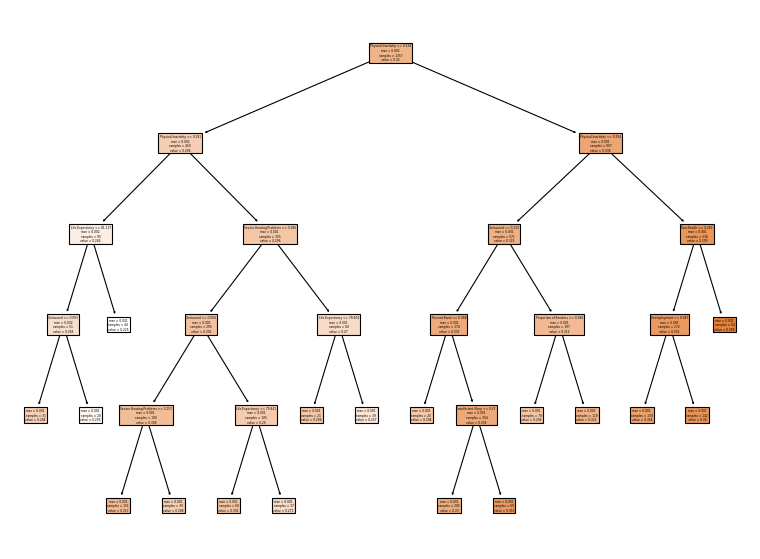

In [34]:
fig = plt.figure(num=None, figsize = (12,9), dpi=80, facecolor='w', edgecolor='k')
tree.plot_tree(best_tree, filled=True, feature_names = X.columns)
print('\t')

## Variable Importance:

* Let's now get a sense of which variables are most important in our tree
* Formally, the importance of a feature is computed as the normalized total reduction of the criteria brought by that figure
* Below, let's show the five most important variables and compute the confusion matrix

In [27]:
importances = pd.DataFrame({'Feature': X_train.columns, 'Importance':np.round(best_tree.feature_importances_, 3)})
importances = importances.sort_values('Importance', ascending=False)
print(importances[:4])

                    Feature  Importance
7       Physical.Inactivity       0.752
1                 Uninsured       0.062
15          Life.Expectancy       0.050
10  Severe.Housing.Problems       0.041


## Takeaways:

* Physical.Inactivity is by far the biggest predictor of Adult.Obesity according to our cost complexity pruning tree, but there are some interesting secondary variables that have a small impact on Adult.Obesity
* Finally, let's run a multiple regression with Physical.Inactivity, Uninsured, Life.Expectancy, and Severe.Housing.Problems

In [29]:
olsmod = smf.ols(formula='Q("Adult.Obesity") ~ Q("Physical.Inactivity") + Q("Severe.Housing.Problems") + Q("Life.Expectancy") + Uninsured', data=county_data)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:     Q("Adult.Obesity")   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     794.0
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        09:44:00   Log-Likelihood:                 5585.6
No. Observations:                2715   AIC:                        -1.116e+04
Df Residuals:                    2710   BIC:                        -1.113e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

## Takeaways:

* 54.0% of the variation in Adult.Obesity is explained by the least-squares regression model
* All three factors look to be statistically-significant, with P-values lower than 0.05 and high t-stats
* Life.Expectancy has the least predictive power of the explanatory variables

## Conclusions

* Obesity has become an important global health crisis in the recent years, and it is worthwhile to look to understand its causes
* In constructing a model for adult obesity in our dataset, physical inactivity is the most influential predictor
* Housing problems and life expectancy are also indicative of obesity rates, which could have broad policy implications for urban housing development, for instance
* In the future, I would be interested in gathering more data on stress levels to see if stress is a strong predictor of obesity

## Thank you for reading!